# Inflation Forecast

## 1. Import the relevant Libraries

In [153]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras as keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils.vis_utils import plot_model
from tqdm.auto import tqdm

## 2. Initialize and plot the dataset

In [4]:
df = pd.read_excel("C:/Users/amore/Desktop/pictet_inflation_forecast.xlsx", index_col=0)
df.head()

,Interest Rate,Inflation,Unemp. Rate,Output Gap,Hourly Wage
Date,,,,,
1969-12-01,0.089719,0.062,0.035,0.023041,0.064309
1970-01-01,0.089768,0.062,0.039,0.013581,0.060897
1970-02-01,0.089782,0.062,0.042,0.011951,0.060510
1970-03-01,0.077623,0.058,0.044,0.010040,0.063291
1970-04-01,0.080963,0.061,0.046,0.007565,0.056604


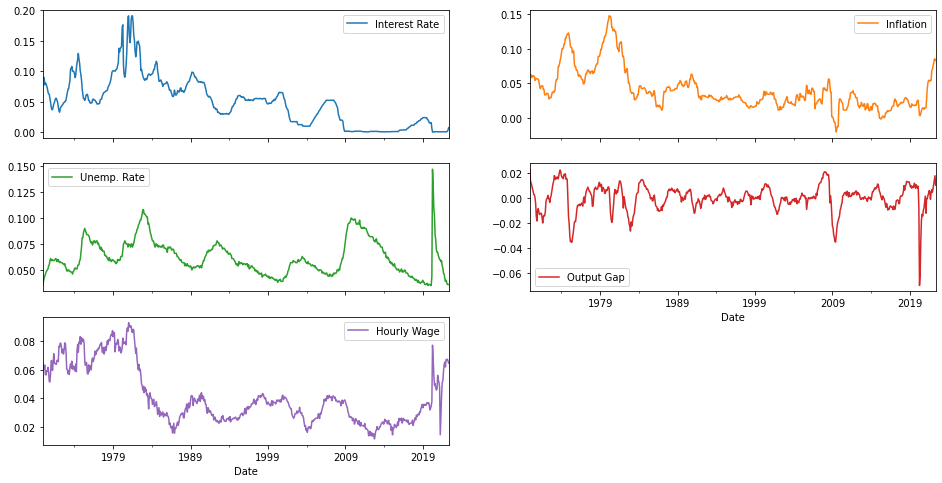

In [5]:
df.plot(figsize=(16, 8), subplots=True, sharex=True, layout=(3, 2))
plt.show()

## 3. Create the train and test set with the adequate shapes used by the model

In [190]:
#Create a function to split the data in an appropriate shape for the LSTM network
def create_seq(data, input_steps, output_steps): 
    X, y = list(), list()
    for i in range(len(data)-(input_steps+output_steps)+1): 
        list_X = []
        list_y = []
        for j in range(input_steps):
            list_X.append(data[i+j])
        for k in range(output_steps): 
            list_y.append(data[i+input_steps + k, 1]) #The 1 is the column index of the inflation.

        X.append(list_X)
        y.append(list_y)

    return np.array(X), np.array(y)

#Example:
#For data=[1, 2, 3, 4], input_steps = 2 and output_steps = 1 we should have something like: x=[[1, 2], [2, 3]], y=[[3], [4]]

In [191]:
input_data = np.array(df)

input_steps = 12
output_steps = 12

#Keep the last 12 data points for our forecast of the next 12 months 
forecast_input = input_data[618:, :]
print(forecast_input.shape)

input_data = input_data[0:618,:]
print(input_data.shape)

#Split the data in an appropriate shape for the LSTM network using out split_seq() function
train_X = create_seq(input_data, input_steps, output_steps)[0]

train_Y = create_seq(input_data, input_steps, output_steps)[1]
train_Y = train_Y.reshape(train_Y.shape[0],train_Y.shape[1],1)

print(train_X.shape, train_Y.shape)

(12, 5)
(618, 5)
(595, 12, 5) (595, 12, 1)


In [192]:
#We have 595 rows in X_train: 595 + the remaining 11 obs in the 595th row of X_train + the next 12 obs for the train_Y = 618
#Split the 595 available obs. into a train set and a test set, we will use the last 50 obs. as the test set
X_test = train_X[545:595, :]
X_train = train_X[0:545, :]

Y_test = train_Y[545:595, :]
Y_train = train_Y[0:545, :]

print(X_test.shape, X_train.shape, Y_test.shape, Y_train.shape)

(50, 12, 5) (545, 12, 5) (50, 12, 1) (545, 12, 1)


## 4. Find the optimal hyperparameters (Epochs, Dropout rate and number of LSTM units)

#### This takes quite a while so I would recommend skipping this part and directly going to the next step where the optimal hyperparameters have already been identified.

In [172]:
n_features = 5

#Hyperparamters to test:
n_epochs = [10, 20, 40]
dropout_rate = [0.2, 0.4]
n_units = [10, 20, 50, 75, 100]

MSE = []

for i in tqdm(n_epochs): 
    for j in dropout_rate: 
        for k in n_units:
            model = Sequential()
            model.add(LSTM(k, activation = 'relu', return_sequences = True, input_shape = (input_steps, n_features)))
            model.add(Dropout(j))
            model.add(LSTM(k, activation = 'relu', return_sequences = False))
            model.add(Dropout(j))
            model.add(Dense(output_steps))
            model.compile(loss = 'mse', optimizer = 'adam')
            training_model = model.fit(X_train, Y_train, epochs = i, verbose = 1, validation_split=.2, shuffle=True)
            MSE.append(training_model.history["val_loss"][-1])


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/10
14/14 [==============================] - 2s 26ms/step - loss: 0.0026 - val_loss: 2.8309e-04
Epoch 2/10
14/14 [==============================] - 0s 9ms/step - loss: 0.0017 - val_loss: 3.9776e-04
Epoch 3/10
14/14 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 6.1376e-04
Epoch 4/10
14/14 [==============================] - 0s 12ms/step - loss: 0.0010 - val_loss: 8.5662e-04
Epoch 5/10
14/14 [==============================] - 0s 10ms/step - loss: 9.4992e-04 - val_loss: 0.0010
Epoch 6/10
14/14 [==============================] - 0s 8ms/step - loss: 9.3121e-04 - val_loss: 0.0011
Epoch 7/10
14/14 [==============================] - 0s 9ms/step - loss: 9.2308e-04 - val_loss: 0.0011
Epoch 8/10
14/14 [==============================] - 0s 9ms/step - loss: 9.1707e-04 - val_loss: 0.0011
Epoch 9/10
14/14 [==============================] - 0s 9ms/step - loss: 9.1151e-04 - val_loss: 0.0011
Epoch 10/10
14/14 [==============================] - 0s 13ms/step - loss: 8.913

Epoch 9/10
14/14 [==============================] - 0s 14ms/step - loss: 4.6334e-04 - val_loss: 5.4730e-04
Epoch 10/10
14/14 [==============================] - 0s 13ms/step - loss: 4.1543e-04 - val_loss: 6.6674e-04
Epoch 1/10
14/14 [==============================] - 3s 39ms/step - loss: 0.0018 - val_loss: 8.9400e-04
Epoch 2/10
14/14 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 5.8191e-04
Epoch 3/10
14/14 [==============================] - 0s 26ms/step - loss: 8.2076e-04 - val_loss: 5.8958e-04
Epoch 4/10
14/14 [==============================] - 0s 26ms/step - loss: 6.5181e-04 - val_loss: 4.3824e-04
Epoch 5/10
14/14 [==============================] - 0s 18ms/step - loss: 5.3670e-04 - val_loss: 4.0520e-04
Epoch 6/10
14/14 [==============================] - 0s 31ms/step - loss: 5.2979e-04 - val_loss: 4.6911e-04
Epoch 7/10
14/14 [==============================] - 0s 29ms/step - loss: 4.3500e-04 - val_loss: 5.3259e-04
Epoch 8/10
14/14 [==========================

Epoch 16/20
14/14 [==============================] - 0s 19ms/step - loss: 2.3042e-04 - val_loss: 5.6077e-04
Epoch 17/20
14/14 [==============================] - 0s 20ms/step - loss: 2.0921e-04 - val_loss: 5.7645e-04
Epoch 18/20
14/14 [==============================] - 0s 18ms/step - loss: 2.0655e-04 - val_loss: 5.7367e-04
Epoch 19/20
14/14 [==============================] - 0s 22ms/step - loss: 2.0233e-04 - val_loss: 6.1865e-04
Epoch 20/20
14/14 [==============================] - 0s 21ms/step - loss: 2.0954e-04 - val_loss: 6.7553e-04
Epoch 1/20
14/14 [==============================] - 2s 36ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 2/20
14/14 [==============================] - 0s 17ms/step - loss: 8.9636e-04 - val_loss: 6.2211e-04
Epoch 3/20
14/14 [==============================] - 0s 29ms/step - loss: 7.5676e-04 - val_loss: 7.0360e-04
Epoch 4/20
14/14 [==============================] - 0s 32ms/step - loss: 6.3720e-04 - val_loss: 5.2427e-04
Epoch 5/20
14/14 [======================

14/14 [==============================] - 0s 19ms/step - loss: 5.2051e-04 - val_loss: 6.6994e-04
Epoch 13/20
14/14 [==============================] - 0s 18ms/step - loss: 5.3600e-04 - val_loss: 5.9160e-04
Epoch 14/20
14/14 [==============================] - 0s 19ms/step - loss: 4.9366e-04 - val_loss: 6.1610e-04
Epoch 15/20
14/14 [==============================] - 0s 18ms/step - loss: 5.1705e-04 - val_loss: 6.8878e-04
Epoch 16/20
14/14 [==============================] - 0s 20ms/step - loss: 4.9023e-04 - val_loss: 6.1981e-04
Epoch 17/20
14/14 [==============================] - 0s 19ms/step - loss: 4.2800e-04 - val_loss: 6.3831e-04
Epoch 18/20
14/14 [==============================] - 0s 18ms/step - loss: 4.0521e-04 - val_loss: 6.0967e-04
Epoch 19/20
14/14 [==============================] - 0s 21ms/step - loss: 3.8880e-04 - val_loss: 5.7147e-04
Epoch 20/20
14/14 [==============================] - 0s 21ms/step - loss: 3.9865e-04 - val_loss: 5.4286e-04
Epoch 1/20
14/14 [======================

Epoch 9/40
14/14 [==============================] - 0s 16ms/step - loss: 8.9670e-04 - val_loss: 0.0010
Epoch 10/40
14/14 [==============================] - 0s 14ms/step - loss: 8.7733e-04 - val_loss: 0.0010
Epoch 11/40
14/14 [==============================] - 0s 20ms/step - loss: 8.6754e-04 - val_loss: 0.0010
Epoch 12/40
14/14 [==============================] - 0s 16ms/step - loss: 8.4706e-04 - val_loss: 9.9031e-04
Epoch 13/40
14/14 [==============================] - 0s 15ms/step - loss: 8.2305e-04 - val_loss: 9.5205e-04
Epoch 14/40
14/14 [==============================] - 0s 19ms/step - loss: 7.9017e-04 - val_loss: 9.1756e-04
Epoch 15/40
14/14 [==============================] - 0s 19ms/step - loss: 7.4842e-04 - val_loss: 9.2499e-04
Epoch 16/40
14/14 [==============================] - 0s 19ms/step - loss: 7.1183e-04 - val_loss: 8.4827e-04
Epoch 17/40
14/14 [==============================] - 0s 18ms/step - loss: 6.9029e-04 - val_loss: 8.0933e-04
Epoch 18/40
14/14 [======================

14/14 [==============================] - 0s 20ms/step - loss: 6.6239e-04 - val_loss: 4.3259e-04
Epoch 6/40
14/14 [==============================] - 0s 18ms/step - loss: 5.5292e-04 - val_loss: 3.7627e-04
Epoch 7/40
14/14 [==============================] - 0s 15ms/step - loss: 4.8933e-04 - val_loss: 3.1437e-04
Epoch 8/40
14/14 [==============================] - 0s 21ms/step - loss: 4.5469e-04 - val_loss: 3.1374e-04
Epoch 9/40
14/14 [==============================] - 0s 18ms/step - loss: 4.0600e-04 - val_loss: 3.7548e-04
Epoch 10/40
14/14 [==============================] - 0s 21ms/step - loss: 3.8037e-04 - val_loss: 3.4189e-04
Epoch 11/40
14/14 [==============================] - 0s 23ms/step - loss: 3.5686e-04 - val_loss: 3.5806e-04
Epoch 12/40
14/14 [==============================] - 0s 23ms/step - loss: 3.2634e-04 - val_loss: 3.9763e-04
Epoch 13/40
14/14 [==============================] - 0s 21ms/step - loss: 3.0525e-04 - val_loss: 4.6030e-04
Epoch 14/40
14/14 [=========================

14/14 [==============================] - 3s 56ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 2/40
14/14 [==============================] - 0s 33ms/step - loss: 8.3219e-04 - val_loss: 5.5702e-04
Epoch 3/40
14/14 [==============================] - 1s 43ms/step - loss: 7.1001e-04 - val_loss: 5.6862e-04
Epoch 4/40
14/14 [==============================] - 1s 39ms/step - loss: 5.4046e-04 - val_loss: 3.7426e-04
Epoch 5/40
14/14 [==============================] - 1s 44ms/step - loss: 4.7096e-04 - val_loss: 3.0347e-04
Epoch 6/40
14/14 [==============================] - 1s 41ms/step - loss: 4.0421e-04 - val_loss: 3.6728e-04
Epoch 7/40
14/14 [==============================] - 1s 42ms/step - loss: 3.5862e-04 - val_loss: 3.6062e-04
Epoch 8/40
14/14 [==============================] - 1s 37ms/step - loss: 3.2308e-04 - val_loss: 4.0859e-04
Epoch 9/40
14/14 [==============================] - 1s 44ms/step - loss: 2.8072e-04 - val_loss: 4.0592e-04
Epoch 10/40
14/14 [==============================] - 1s 

Epoch 38/40
14/14 [==============================] - 0s 18ms/step - loss: 5.1436e-04 - val_loss: 7.4814e-04
Epoch 39/40
14/14 [==============================] - 0s 19ms/step - loss: 5.0296e-04 - val_loss: 7.1231e-04
Epoch 40/40
14/14 [==============================] - 0s 17ms/step - loss: 5.2339e-04 - val_loss: 8.5943e-04
Epoch 1/40
14/14 [==============================] - 5s 54ms/step - loss: 0.0024 - val_loss: 3.1447e-04
Epoch 2/40
14/14 [==============================] - 0s 15ms/step - loss: 0.0013 - val_loss: 6.7497e-04
Epoch 3/40
14/14 [==============================] - 0s 13ms/step - loss: 0.0010 - val_loss: 6.4723e-04
Epoch 4/40
14/14 [==============================] - 0s 15ms/step - loss: 9.5210e-04 - val_loss: 6.9945e-04
Epoch 5/40
14/14 [==============================] - 0s 17ms/step - loss: 8.4665e-04 - val_loss: 7.2692e-04
Epoch 6/40
14/14 [==============================] - 0s 14ms/step - loss: 7.2962e-04 - val_loss: 6.4636e-04
Epoch 7/40
14/14 [============================

14/14 [==============================] - 0s 21ms/step - loss: 1.9630e-04 - val_loss: 4.8718e-04
Epoch 35/40
14/14 [==============================] - 0s 24ms/step - loss: 1.7326e-04 - val_loss: 5.2590e-04
Epoch 36/40
14/14 [==============================] - 0s 26ms/step - loss: 2.0306e-04 - val_loss: 4.5491e-04
Epoch 37/40
14/14 [==============================] - 0s 22ms/step - loss: 2.0861e-04 - val_loss: 4.5796e-04
Epoch 38/40
14/14 [==============================] - 0s 23ms/step - loss: 1.8899e-04 - val_loss: 5.8680e-04
Epoch 39/40
14/14 [==============================] - 0s 21ms/step - loss: 1.7697e-04 - val_loss: 5.6349e-04
Epoch 40/40
14/14 [==============================] - 0s 26ms/step - loss: 1.8962e-04 - val_loss: 4.9264e-04
Epoch 1/40
14/14 [==============================] - 4s 58ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 2/40
14/14 [==============================] - 0s 24ms/step - loss: 0.0010 - val_loss: 5.7235e-04
Epoch 3/40
14/14 [==============================] - 0s

14/14 [==============================] - 1s 46ms/step - loss: 1.4979e-04 - val_loss: 5.1439e-04
Epoch 31/40
14/14 [==============================] - 1s 49ms/step - loss: 1.6762e-04 - val_loss: 5.0113e-04
Epoch 32/40
14/14 [==============================] - 1s 47ms/step - loss: 1.7224e-04 - val_loss: 4.6021e-04
Epoch 33/40
14/14 [==============================] - 1s 44ms/step - loss: 1.5682e-04 - val_loss: 5.2084e-04
Epoch 34/40
14/14 [==============================] - 1s 40ms/step - loss: 1.6150e-04 - val_loss: 5.0353e-04
Epoch 35/40
14/14 [==============================] - 1s 45ms/step - loss: 1.5468e-04 - val_loss: 5.5822e-04
Epoch 36/40
14/14 [==============================] - 1s 48ms/step - loss: 1.6715e-04 - val_loss: 5.5420e-04
Epoch 37/40
14/14 [==============================] - 1s 47ms/step - loss: 1.5730e-04 - val_loss: 4.4956e-04
Epoch 38/40
14/14 [==============================] - 1s 43ms/step - loss: 1.5832e-04 - val_loss: 4.4665e-04
Epoch 39/40
14/14 [=====================

In [181]:
print("Index of the minimum MSE from the testing above:", MSE.index(min(MSE)))
print("Minimum MSE from the validation set:", min(MSE))

Index of the minimum MSE from the testing above: 3
Minimum MSE from the validation set: 0.0003743511624634266


In [182]:
print("The 9th index corresponds to the following combination:\n", "Number of Epochs: 10 \n", "Dropout rate: 0.2 \n", "Number of LSTM units: 75")

The 9th index corresponds to the following combination:
 Number of Epochs: 10 
 Dropout rate: 0.2 
 Number of LSTM units: 75


## 5. Compute the RMSE and MAE of the predictions for the test set

#### Because the model is non-deterministic, we will generate 50 times the predictions for the test set and compute their average RMSE and MAE.

In [187]:
n = 50
results = []
for i in tqdm(range(n)):
    model = Sequential()
    model.add(LSTM(75, activation = 'relu', return_sequences = True, input_shape = (input_steps, n_features)))
    model.add(Dropout(0.2))
    model.add(LSTM(75, activation = 'relu', return_sequences = False))
    model.add(Dropout(0.2))
    model.add(Dense(output_steps))
    model.compile(loss = 'mse', optimizer = 'adam')
    
    training_model = model.fit(X_train, Y_train, epochs= 10, verbose=1)
    
    yhat = model.predict(X_test)
    results.append(yhat)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/10
18/18 [==============================] - 2s 11ms/step - loss: 0.0013
Epoch 2/10
18/18 [==============================] - 0s 17ms/step - loss: 7.7199e-04
Epoch 3/10
18/18 [==============================] - 0s 25ms/step - loss: 5.2978e-04
Epoch 4/10
18/18 [==============================] - 0s 21ms/step - loss: 4.6055e-04
Epoch 5/10
18/18 [==============================] - 0s 22ms/step - loss: 4.6902e-04
Epoch 6/10
18/18 [==============================] - 0s 26ms/step - loss: 4.1691e-04
Epoch 7/10
18/18 [==============================] - 0s 16ms/step - loss: 4.1823e-04
Epoch 8/10
18/18 [==============================] - 0s 23ms/step - loss: 3.8122e-04
Epoch 9/10
18/18 [==============================] - 0s 24ms/step - loss: 4.0952e-04
Epoch 10/10
18/18 [==============================] - 0s 24ms/step - loss: 3.2559e-04
Epoch 1/10
18/18 [==============================] - 2s 11ms/step - loss: 0.0016
Epoch 2/10
18/18 [==============================] - 0s 23ms/step - loss: 9.2409e-04

18/18 [==============================] - 0s 24ms/step - loss: 3.5447e-04
Epoch 9/10
18/18 [==============================] - 0s 27ms/step - loss: 3.4431e-04
Epoch 10/10
18/18 [==============================] - 0s 25ms/step - loss: 3.2681e-04
Epoch 1/10
18/18 [==============================] - 2s 12ms/step - loss: 0.0012
Epoch 2/10
18/18 [==============================] - 0s 23ms/step - loss: 7.2525e-04
Epoch 3/10
18/18 [==============================] - 0s 24ms/step - loss: 5.0288e-04
Epoch 4/10
18/18 [==============================] - 0s 26ms/step - loss: 4.5885e-04
Epoch 5/10
18/18 [==============================] - 0s 24ms/step - loss: 4.0709e-04
Epoch 6/10
18/18 [==============================] - 0s 26ms/step - loss: 3.8960e-04
Epoch 7/10
18/18 [==============================] - 0s 24ms/step - loss: 3.6053e-04
Epoch 8/10
18/18 [==============================] - 0s 27ms/step - loss: 3.3822e-04
Epoch 9/10
18/18 [==============================] - 0s 25ms/step - loss: 2.9253e-04
Epoch 

18/18 [==============================] - 0s 20ms/step - loss: 4.0839e-04
Epoch 7/10
18/18 [==============================] - 0s 17ms/step - loss: 3.5816e-04
Epoch 8/10
18/18 [==============================] - 0s 20ms/step - loss: 3.4257e-04
Epoch 9/10
18/18 [==============================] - 0s 20ms/step - loss: 3.3351e-04
Epoch 10/10
18/18 [==============================] - 0s 16ms/step - loss: 3.2309e-04
Epoch 1/10
18/18 [==============================] - 2s 11ms/step - loss: 0.0014
Epoch 2/10
18/18 [==============================] - 0s 27ms/step - loss: 8.3161e-04
Epoch 3/10
18/18 [==============================] - 1s 29ms/step - loss: 6.4750e-04
Epoch 4/10
18/18 [==============================] - 0s 16ms/step - loss: 4.9561e-04
Epoch 5/10
18/18 [==============================] - 0s 24ms/step - loss: 6.2788e-04
Epoch 6/10
18/18 [==============================] - 0s 20ms/step - loss: 4.2724e-04
Epoch 7/10
18/18 [==============================] - 0s 20ms/step - loss: 3.9267e-04
Epoch 

18/18 [==============================] - 0s 27ms/step - loss: 4.8405e-04
Epoch 5/10
18/18 [==============================] - 1s 28ms/step - loss: 4.0784e-04
Epoch 6/10
18/18 [==============================] - 1s 29ms/step - loss: 3.9195e-04
Epoch 7/10
18/18 [==============================] - 1s 31ms/step - loss: 4.4598e-04
Epoch 8/10
18/18 [==============================] - 1s 28ms/step - loss: 3.8124e-04
Epoch 9/10
18/18 [==============================] - 1s 30ms/step - loss: 3.5730e-04
Epoch 10/10
18/18 [==============================] - 1s 28ms/step - loss: 3.1950e-04
Epoch 1/10
18/18 [==============================] - 3s 14ms/step - loss: 0.0015
Epoch 2/10
18/18 [==============================] - 1s 30ms/step - loss: 8.6051e-04
Epoch 3/10
18/18 [==============================] - 1s 31ms/step - loss: 6.1421e-04
Epoch 4/10
18/18 [==============================] - 0s 23ms/step - loss: 4.5261e-04
Epoch 5/10
18/18 [==============================] - 1s 32ms/step - loss: 3.9575e-04
Epoch 

18/18 [==============================] - 1s 30ms/step - loss: 8.3355e-04
Epoch 3/10
18/18 [==============================] - 1s 30ms/step - loss: 6.3778e-04
Epoch 4/10
18/18 [==============================] - 1s 32ms/step - loss: 4.5887e-04
Epoch 5/10
18/18 [==============================] - 0s 26ms/step - loss: 4.3542e-04
Epoch 6/10
18/18 [==============================] - 1s 31ms/step - loss: 3.6994e-04
Epoch 7/10
18/18 [==============================] - 0s 23ms/step - loss: 3.6576e-04
Epoch 8/10
18/18 [==============================] - 0s 27ms/step - loss: 3.2692e-04
Epoch 9/10
18/18 [==============================] - 1s 30ms/step - loss: 3.0940e-04
Epoch 10/10
18/18 [==============================] - 1s 32ms/step - loss: 3.0769e-04
Epoch 1/10
18/18 [==============================] - 3s 18ms/step - loss: 0.0014
Epoch 2/10
18/18 [==============================] - 1s 31ms/step - loss: 7.5205e-04
Epoch 3/10
18/18 [==============================] - 1s 28ms/step - loss: 5.7314e-04
Epoch 

Epoch 10/10
18/18 [==============================] - 1s 36ms/step - loss: 3.6273e-04
Epoch 1/10
18/18 [==============================] - 4s 16ms/step - loss: 0.0014
Epoch 2/10
18/18 [==============================] - 1s 28ms/step - loss: 8.2624e-04
Epoch 3/10
18/18 [==============================] - 1s 30ms/step - loss: 6.0557e-04
Epoch 4/10
18/18 [==============================] - 1s 29ms/step - loss: 4.6647e-04
Epoch 5/10
18/18 [==============================] - 1s 29ms/step - loss: 4.1825e-04
Epoch 6/10
18/18 [==============================] - 0s 28ms/step - loss: 3.9407e-04
Epoch 7/10
18/18 [==============================] - 1s 30ms/step - loss: 3.4655e-04
Epoch 8/10
18/18 [==============================] - 0s 26ms/step - loss: 3.2363e-04
Epoch 9/10
18/18 [==============================] - 0s 26ms/step - loss: 3.0470e-04
Epoch 10/10
18/18 [==============================] - 0s 25ms/step - loss: 3.0413e-04


In [188]:
Y_test = np.reshape(Y_test, (50, 12))
RMSE, AME = [], []
for i in range(50):
    RMSE.append(mean_squared_error(Y_test, results[i], squared=False))
    AME.append(mean_absolute_error(Y_test, results[i]))

print(np.mean(RMSE), np.mean(MSE))

0.008994678782221445 0.0006078266470770662


## 6. Forecast and plot the next 12 months of inflation

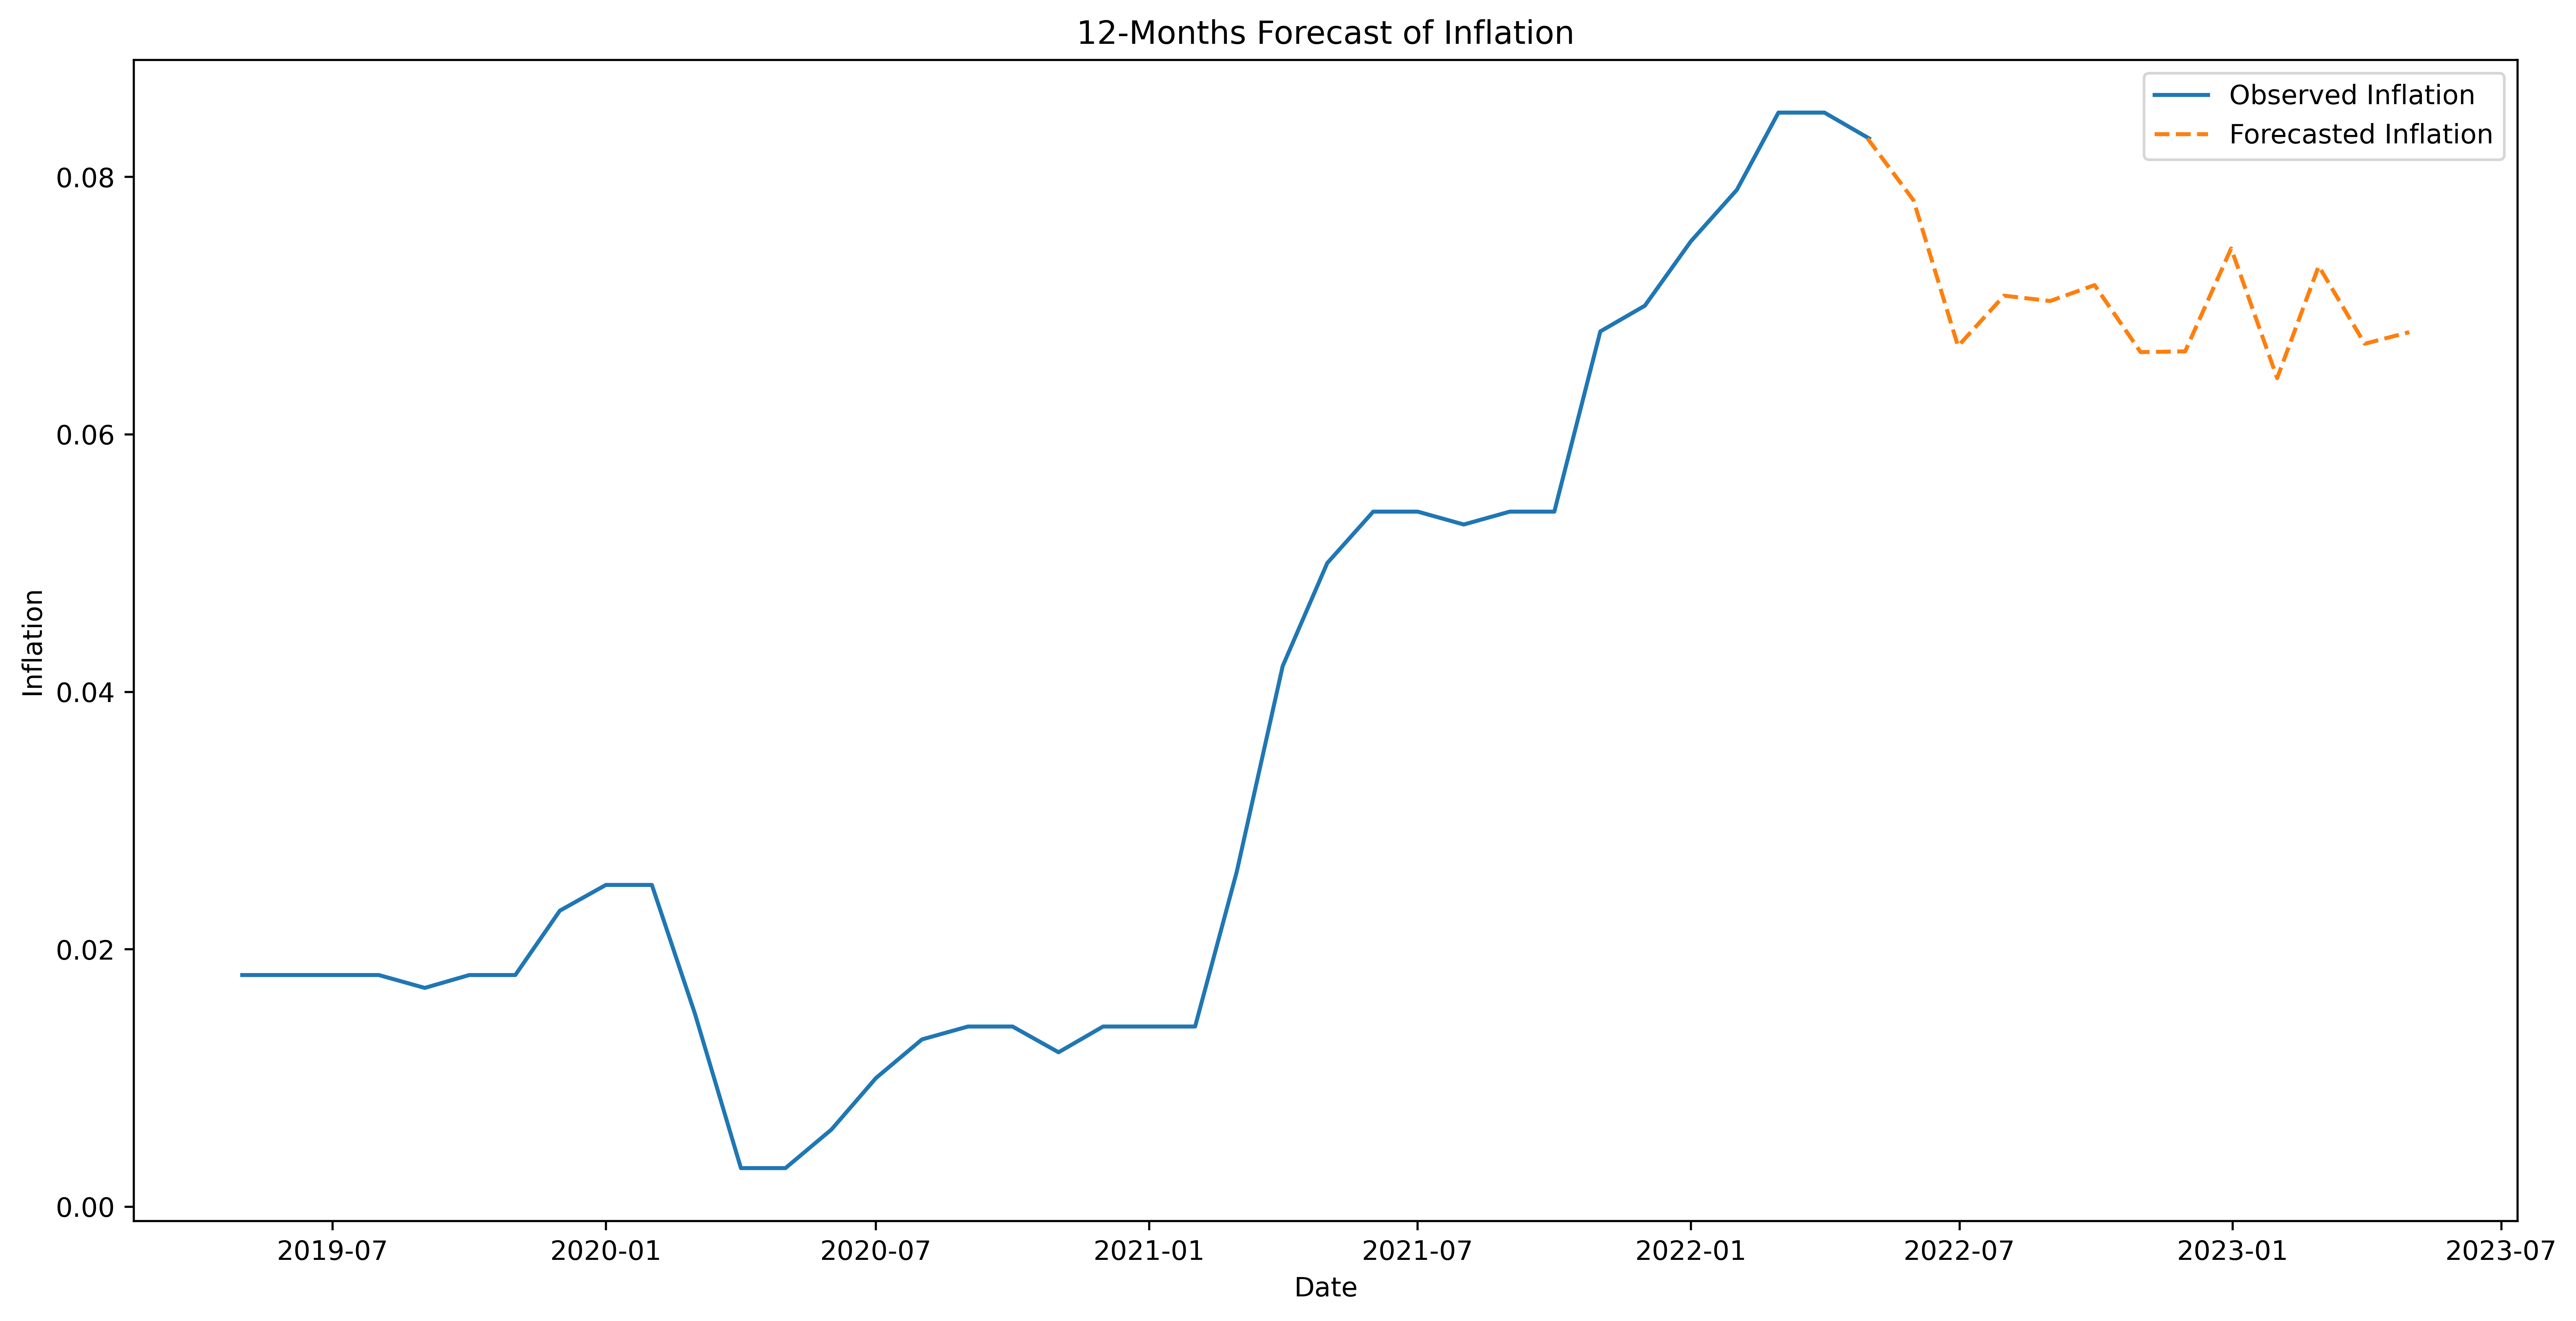

In [186]:
forecast = model.predict(forecast_input.reshape(1,12,5))
forecast = np.reshape(forecast, (12, 1))

fcst_plot = np.array(pd.concat([pd.DataFrame([df["Inflation"][-1]]), pd.DataFrame(forecast.T)], axis=1)).T

fig = plt.figure(figsize=(16, 8), dpi=500)
plt.plot(df.loc["2019-05-01":"2022-05-01", ["Inflation"]], label="Observed Inflation")
plt.plot(pd.DataFrame(fcst_plot, index=pd.date_range("04/01/2022",periods=13,freq="M")), linestyle="dashed", label="Forecasted Inflation")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.title("12-Months Forecast of Inflation")
plt.show()